In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import latin
import copy

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif',size=20)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20#20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def plot_gp(X, m, C, training_points=None):
    plt.figure(figsize = (6, 6))
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)), # 95% confidence interval of a Gaussian is
                     m[:,0] + 1.96*np.sqrt(np.diag(C)), # .. contained within mean +/- 1.96*s.d.
                     alpha=0.5, color = 'darkcyan', label = 'uncertainty')
    # Plot GP mean and initial training points
    plt.plot(X, m, "-",linewidth=3, label = "mean")
    #plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("y")
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 4))
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2, alpha = 1.0, label =  'training points')
        #plt.legend(labels=["GP fit", "sample points"])


Name : GP regression
Objective : 89.74882548648765
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       86.29858077561597  |      +ve      |        
  rbf.lengthscale          |  3.8528738466543064e-07  |      +ve      |        
  Gaussian_noise.variance  |     0.09624697501102805  |      +ve      |        
  rbf.         |                   value  |  constraints  |  priors
  variance     |       86.29858077561597  |      +ve      |        
  lengthscale  |  3.8528738466543064e-07  |      +ve      |        


<Figure size 1080x432 with 0 Axes>

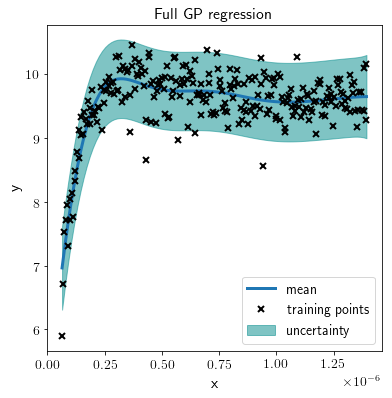

In [2]:
X, Y = np.loadtxt('Metamaterial/qgp-unitcell-data-256.txt')
X = np.array(X).reshape(-1, 1)
Y = np.array(Y).reshape(-1, 1)


np.random.seed(40918)

# The covariance in the latent function is an RBF with l=0.2
k = GPy.kern.RBF( 1, lengthscale=2.e-7)

# Our sample space for predictions from the posterior
Xnew = np.linspace( min(X), max(X), 100)

# Prepare figure enviroment
plt.figure(figsize=(15, 6))

## First we fit with full GP regression 
m = GPy.models.GPRegression(X, Y, kernel=k)
m.optimize()
print(m)
#m.Gaussian_noise.variance = 0.01

# Note we don't even optimise the hyperparameters because they are known here
mean_full, Cov_full = m.predict(Xnew, full_cov=True)

# We plot our regression fit of the likelihood
plot_gp(Xnew, mean_full, Cov_full, training_points=(X, Y))
plt.title("Full GP regression")
plt.legend()
print(k)

# select 20 points

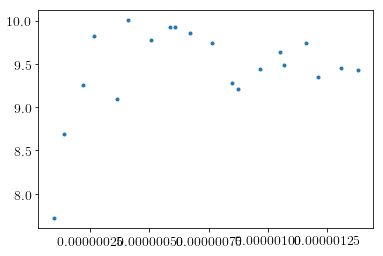

In [3]:
np.random.seed(40918)

x1 = np.sort(X[:, -1])
y1 = Y[np.argsort(X[:, -1])][:, -1]


#SELECT THE SUBSET OF N POINTS FOR QGP
problem = {
    'num_vars': 1,
    'names': ['k'],
    'bounds': [[0, len(X)]]
}
idx = np.array(latin.sample(problem, 20))
idx = idx.astype('int')
Xtr = x1[idx] 
Ytr = y1[idx]

plt.plot(Xtr, Ytr, '.')



<Figure size 864x432 with 0 Axes>

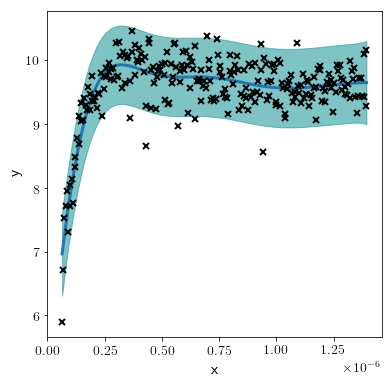

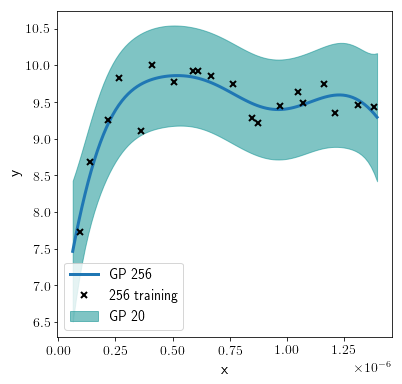

In [4]:
m4 = GPy.models.GPRegression(Xtr, Ytr , m.kern)
m4.Gaussian_noise.variance = m.Gaussian_noise.variance

mean4, cov4 = m4.predict(Xnew, full_cov=True)

plt.figure(figsize=(12, 6))
plot_gp(Xnew, mean_full, Cov_full, training_points=(X, Y))
plot_gp(Xnew, mean4, cov4, training_points=(Xtr, Ytr))
plt.legend(['GP 256', '256 training', 'GP 20'])


K = m.kern.K(Xtr, Xtr)

In [36]:
# import matplotlib.style as style 
# style.use('default')


# SMALL_SIZE = 14
# MEDIUM_SIZE = 16
# BIGGER_SIZE = 20#20

# plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif',size=20)

# plt.rc('font', size=12)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


(20,)
20


 /home/gawel/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/matplotlib/transforms.py:827: ComplexWarning:Casting complex values to real discards the imaginary part
 /home/gawel/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/matplotlib/transforms.py:954: ComplexWarning:Casting complex values to real discards the imaginary part
 /home/gawel/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/matplotlib/transforms.py:827: ComplexWarning:Casting complex values to real discards the imaginary part


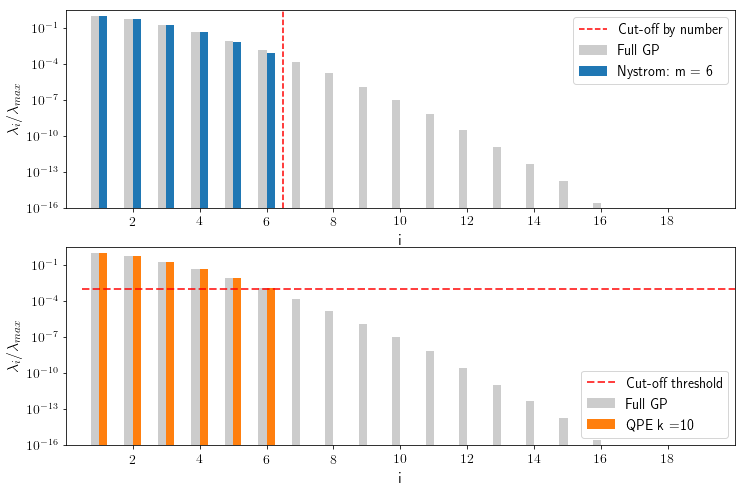

In [5]:
%matplotlib inline
#Nystromm
M = 6
N = 20
np.random.seed(7)
id = np.random.choice(range(N), N-M, replace = False)
Kn1 = np.delete(K, id, axis = 1)
Kn = np.delete(Kn1, id, axis = 0)

Ktild = Kn1@np.linalg.inv(Kn+1e-6*np.eye(len(Kn)))@Kn1.T

eig_ny, mu_ny = np.linalg.eig(Ktild)
eig_ny = np.round(eig_ny, 10)

eig, mu = np.linalg.eig(K)
dk = abs(eig.real)/max(eig.real)
threshold = 2**10
resolution_k = threshold
D_appr = copy.deepcopy(dk)
D_appr[np.where(dk<np.max(dk)/threshold)] = 0.
D_appr = D_appr.real
print(D_appr.shape)
print(len(dk))

width = 0.25
fig = plt.figure(figsize = (12,8 ))
ax = plt.subplot(211)
ax.set_yscale('log')

ax.bar(np.arange(1, len(dk)+1)-width*0.5, dk, width, align='center', label = 'Full GP', color = 'black', alpha = 0.2)
#ax.bar(np.arange(len(D_appr))+width*1.5, D_appr, width, #yerr = np.max(D_appr)/resolution_k,
#       capsize=5, align='center', label = 'QPE')
ax.bar(np.arange(1, 21)+width*.5, eig_ny/max(eig) ,width,  align='center', label = 'Nystrom: m = 6')

#ax.plot(np.ones(2)*6.5, np.linspace(1e-16, 1, 10), '--r',  linewidth=2, label = 'Cut-off threshold', 
#        alpha = 0.75)
plt.axvline(x=6.5, color='r', linestyle='--', label = 'Cut-off by number')

plt.ylabel(r'$\lambda_i/\lambda_{max}$')#, fontsize=15)
plt.xticks(range(2, 20, 2))
plt.xlabel('i', fontsize=16)

ax.set_ylim(1e-16, 3)
ax.set_xlim(0, 20)

plt.legend()


ax2 = plt.subplot(212)
ax2.set_yscale('log')
plt.ylabel(r'$\lambda_i/\lambda_{max}$')

ax2.bar(np.arange(1, len(dk)+1)-width*0.5, dk, width, align='center', label = 'Full GP', color = 'black', alpha = 0.2)
ax2.bar(np.arange(1, len(D_appr)+1)+width*0.5, D_appr, width,color = 'C1', #yerr = np.max(D_appr)/resolution_k,
       capsize=5, align='center', label = 'QPE k =10')
#ax.bar(np.arange(20)+width*1.5, eig_ny/max(eig) ,width,  align='center', label = 'Nystrom')
plt.xticks(range(2, 20, 2))
plt.xlabel('i', fontsize=16)
ax2.plot(np.linspace(0.5, 20,20 ),np.ones(20)/resolution_k, '--r',  linewidth=2, label = 'Cut-off threshold', 
        alpha = 0.75)
ax2.set_ylim(1e-16, 3)
ax2.set_xlim(0, 20)
plt.legend()

#fig.tight_layout()

#supttl =fig.suptitle('Comparison of different strategies for eigenspectrum cut-off', size = 22)

#fig.savefig('/home/gawel/thesis/chapter_3/figures/eigenspectrum_p1.pdf')
#fig.savefig('/home/gawel/presentation_figs/PNGs/eigenspectrum_p1.png', dpi = 400)
#fig.savefig('/home/gawel/presentation_figs/SVGs/eigenspectrum_p1.svg', dpi = 400)

fig.savefig('Figures/7A_eigenspectrum_p1.pdf',
            #bbox_extra_artists=[ supttl],
            bbox_inches='tight')

# 2nd example

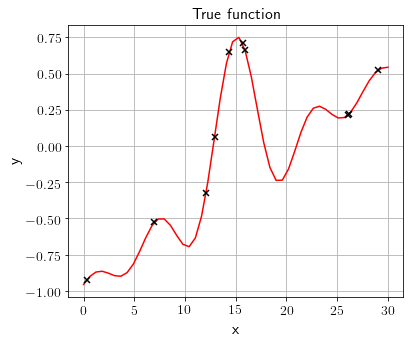

In [6]:
np.random.seed(8)
def f(X):
    return -1 + .05*X + np.sin(X-15)/(X-15)

X = np.random.uniform(0,30, 10)
#X = X[~np.logical_and(X>-2,X<3)] #Remove points between -2 and 3 (just for illustration) 
#X = np.hstack([np.random.uniform(0,1,1),X]) #Prepend a point between -1 and 1  (just for illustration)
error = np.random.normal(0,.1,X.size)
Y = f(X)# + error
plt.figure(figsize = (6, 5))
plt.plot(np.linspace(0,30),f(np.linspace(0,30)),'r-')
plt.plot(X,Y,'kx',mew=1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('True function')
plt.grid()

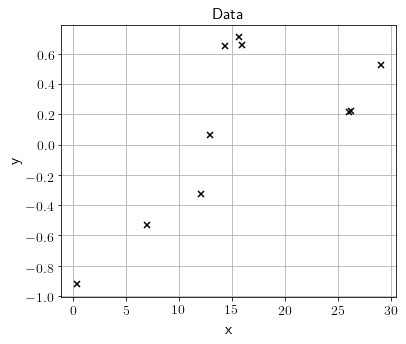

In [7]:
plt.figure(figsize = (6, 5))
#plt.plot(np.linspace(0,30),f(np.linspace(0,30)),'r-')
plt.plot(X,Y,'kx',mew=1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.grid()

Optimization restart 1/5, f = 8.117865707345246
Optimization restart 2/5, f = -3.3918523108470655
Optimization restart 3/5, f = -3.391852309753334
Optimization restart 4/5, f = -3.3918522098943917
Optimization restart 5/5, f = -3.391852293823895

Name : GP regression
Objective : -3.3918523108470655
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      0.3718144674648322  |      +ve      |        
  rbf.lengthscale          |      2.8074017962373694  |      +ve      |        
  Gaussian_noise.variance  |  1.5838863519123954e-13  |      +ve      |        
  rbf.         |               value  |  constraints  |  priors
  variance     |  0.3718144674648322  |      +ve      |        
  lengthscale  |  2.8074017962373694  |      +ve      |        


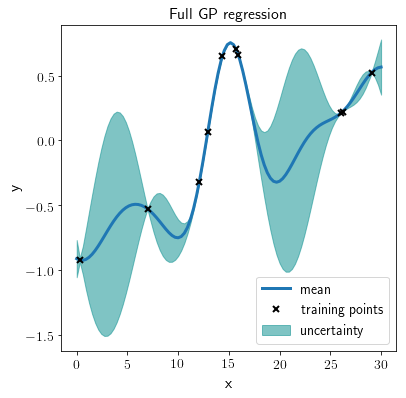

In [8]:
## First we fit with full GP regression 
m2 = GPy.models.GPRegression(X[:, None], Y[:,None], kernel=k)
m#2.Gaussian_noise.variance = 0.01
#m2.Gaussian_noise.variance.fix()

m2.optimize()
m2.optimize_restarts(5)
print(m2)

Xnew = np.linspace(0, 30, 100)[:, None]

# Note we don't even optimise the hyperparameters because they are known here
mean_full2, Cov_full2 = m2.predict(Xnew, full_cov=True)
# We plot our regression fit of the likelihood
#plt.figure(figsize = (6, 5))

plot_gp(Xnew, mean_full2, Cov_full2, training_points=(X, Y))
plt.title("Full GP regression")
plt.legend(loc = 'lower right')
print(m.kern)

(100, 1)


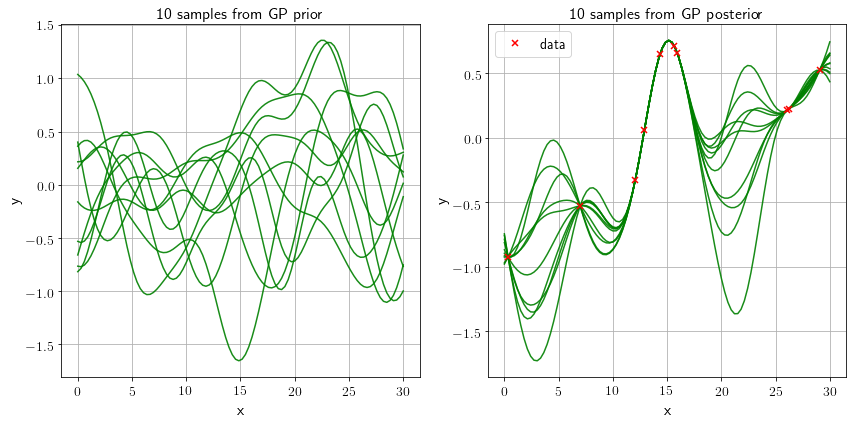

In [9]:
# Take care of some general properties of the plots:
# from matplotlib import style
# style.use('seaborn')

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif',size=20)

# SMALL_SIZE = 14
# MEDIUM_SIZE = 16
# BIGGER_SIZE = 20#20

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


print(Xnew[:].shape)
mu_prior = np.zeros((100)) # we have 250 sample inputs
# Get the covariance matrix
C  = m2.kern.K(Xnew[:], Xnew[:])
Z  = np.random.multivariate_normal(mu_prior, C, 50)


fig = plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
for j in range(10):
    plt.plot(Xnew[:],Z[j,:], '-g', alpha = .9)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.title('10 samples from GP prior')

Z2 = np.random.multivariate_normal(mean_full2[:, -1], Cov_full2, 200)

plt.subplot(1, 2, 2)
for j in range(10):
    plt.plot(Xnew[:],Z2[j,:], '-g', alpha = 0.9)
plt.plot(X,Y,'rx',mew=1.5, label = 'data')
plt.legend()

plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.title('10 samples from GP posterior')
#plt.show()
fig.tight_layout()
#fig.savefig('/home/gawel/thesis/chapter_2/figures/foo.pdf')
# Sample 5 times from a multivariate Gaussian 

  rbf.         |               value  |  constraints  |  priors
  variance     |  0.3718144674648322  |      +ve      |        
  lengthscale  |  2.8074017962373694  |      +ve      |        


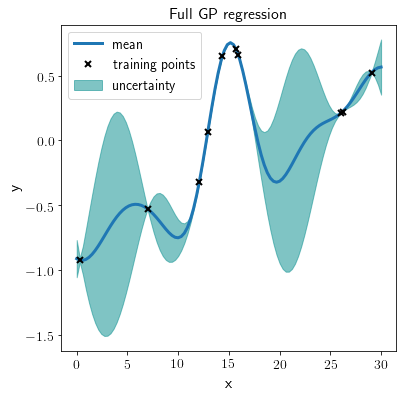

In [10]:
#fig = plt.figure(figsize = (6, 6))

plot_gp(Xnew, mean_full2, Cov_full2, training_points=(X, Y))
plt.title("Full GP regression")
plt.legend()
print(m.kern)

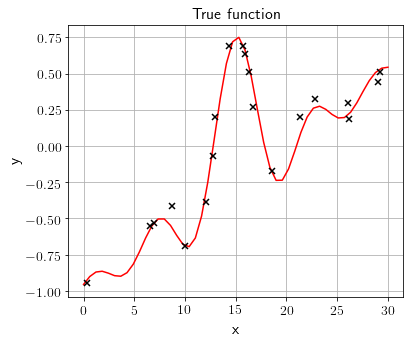

In [13]:
np.random.seed(8)
def f(X):
    return -1 + .05*X + np.sin(X-15)/(X-15)

X = np.random.uniform(0,30, 20)
#X = X[~np.logical_and(X>-2,X<3)] #Remove points between -2 and 3 (just for illustration) 
#X = np.hstack([np.random.uniform(0,1,1),X]) #Prepend a point between -1 and 1  (just for illustration)
error = np.random.normal(0,.1,X.size)
Y = f(X) + error
plt.figure(figsize = (6, 5))
plt.plot(np.linspace(0,30),f(np.linspace(0,30)),'r-')
plt.plot(X,Y,'kx',mew=1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('True function')
plt.grid()

Optimization restart 1/5, f = -1.5809454367638107
Optimization restart 2/5, f = -1.580945436782594
Optimization restart 3/5, f = -1.5809454367743925
Optimization restart 4/5, f = -1.58094543678253
Optimization restart 5/5, f = -1.5809454367811728

Name : GP regression
Objective : -1.580945436782594
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |   0.33094838419716066  |      +ve      |        
  rbf.lengthscale          |    2.3964220511616245  |      +ve      |        
  Gaussian_noise.variance  |  0.004500951431576626  |      +ve      |        
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.33094838419716066  |      +ve      |        
  lengthscale  |   2.3964220511616245  |      +ve      |        


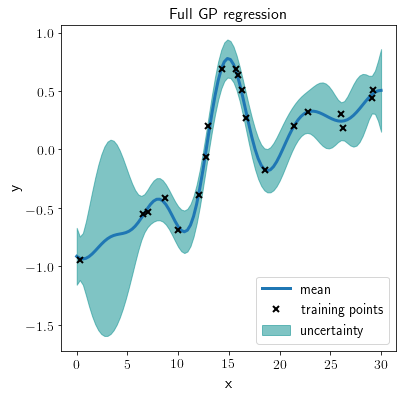

In [14]:
## First we fit with full GP regression 
m2 = GPy.models.GPRegression(X[:, None], Y[:,None], kernel=k)
m#2.Gaussian_noise.variance = 0.01
#m2.Gaussian_noise.variance.fix()

m2.optimize()
m2.optimize_restarts(5)
print(m2)

Xnew = np.linspace(0, 30, 100)[:, None]

# Note we don't even optimise the hyperparameters because they are known here
mean_full2, Cov_full2 = m2.predict(Xnew, full_cov=True)
# We plot our regression fit of the likelihood
#plt.figure(figsize = (6, 5))

plot_gp(Xnew, mean_full2, Cov_full2, training_points=(X, Y))
plt.title("Full GP regression")
plt.legend(loc = 'lower right')
print(m.kern)

(100, 1)


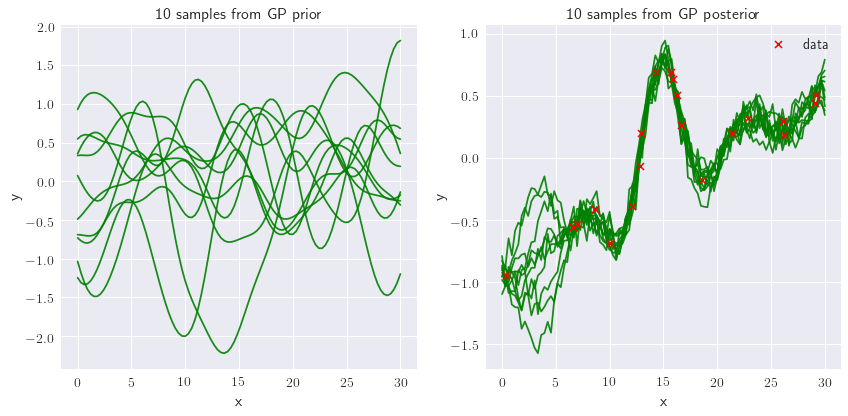

In [15]:
# Take care of some general properties of the plots:
from matplotlib import style
style.use('seaborn')

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif',size=20)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20#20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


print(Xnew[:].shape)
mu_prior = np.zeros((100)) # we have 250 sample inputs
# Get the covariance matrix
C  = m2.kern.K(Xnew[:], Xnew[:])
Z  = np.random.multivariate_normal(mu_prior, C, 50)


fig = plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
for j in range(10):
    plt.plot(Xnew[:],Z[j,:], '-g', alpha = .9)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.title('10 samples from GP prior')

Z2 = np.random.multivariate_normal(mean_full2[:, -1], Cov_full2, 200)

plt.subplot(1, 2, 2)
for j in range(10):
    plt.plot(Xnew[:],Z2[j,:], '-g', alpha = 0.9)
plt.plot(X,Y,'rx',mew=1.5, label = 'data')
plt.legend()

plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.title('10 samples from GP posterior')
#plt.show()
fig.tight_layout()
#fig.savefig('/home/gawel/thesis/chapter_2/figures/foo.pdf')
# Sample 5 times from a multivariate Gaussian 

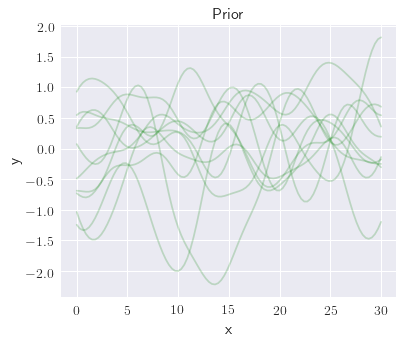

In [16]:
plt.figure(figsize = (6, 5))
for j in range(10):
    plt.plot(Xnew[:],Z[j,:], '-g', alpha = 0.2)
#plt.plot(X,Y,'kx',mew=1.5)

plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.title('Prior')
plt.show()

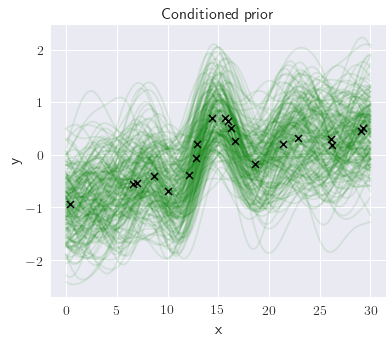

In [17]:
Z2 = np.random.multivariate_normal(mean_full2[:, -1], C, 200)

plt.figure(figsize = (6, 5))
for j in range(200):
    plt.plot(Xnew[:],Z2[j,:], '-g', alpha = 0.1)
plt.plot(X,Y,'kx',mew=1.5)

plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.title('Conditioned prior')
plt.show()

<Figure size 432x360 with 0 Axes>

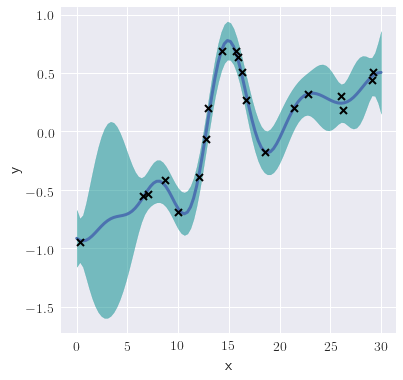

In [18]:
plt.figure(figsize = (6, 5))

plot_gp(Xnew, mean_full2, Cov_full2, training_points=(X, Y))
#plt.title("Posterior")
plt.grid(True)
#plt.legend()

In [19]:

K = m2.kern.K(X[:, None], X[:,None])
print(K.size)

400


(20,)
20


 /home/gawel/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/matplotlib/transforms.py:827: ComplexWarning:Casting complex values to real discards the imaginary part
 /home/gawel/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/matplotlib/transforms.py:954: ComplexWarning:Casting complex values to real discards the imaginary part


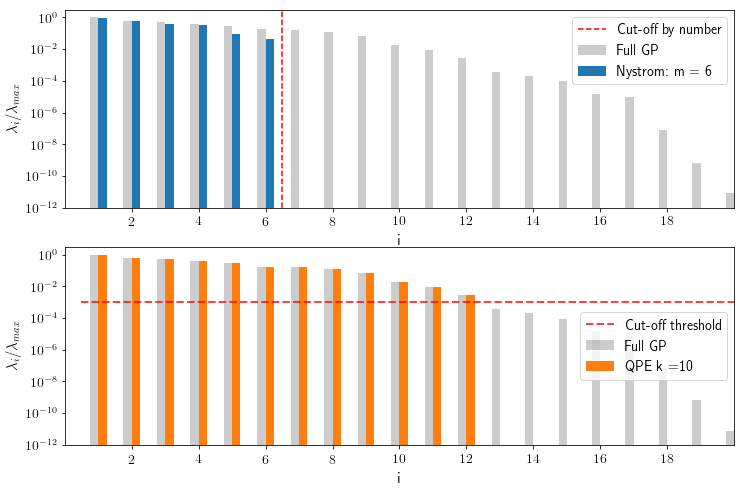

In [20]:
import matplotlib.style as style 
style.use('default')


SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20#20

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif',size=20)

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


%matplotlib inline
#Nystromm
M = 6
N = 20
np.random.seed(7)
id = np.random.choice(range(N), N-M, replace = False)
Kn1 = np.delete(K, id, axis = 1)
Kn = np.delete(Kn1, id, axis = 0)

Ktild = Kn1@np.linalg.inv(Kn+1e-6*np.eye(len(Kn)))@Kn1.T

eig_ny, mu_ny = np.linalg.eig(Ktild)
eig_ny = np.round(eig_ny, 10)

eig, mu = np.linalg.eig(K)
dk = abs(eig.real)/max(eig.real)
threshold = 2**10
resolution_k = threshold
D_appr = copy.deepcopy(dk)
D_appr[np.where(dk<np.max(dk)/threshold)] = 0.
D_appr = D_appr.real
print(D_appr.shape)
print(len(dk))

width = 0.25
fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(211)
ax.set_yscale('log')

ax.bar(np.arange(1, len(dk)+1)-width*0.5, dk, width, align='center', label = 'Full GP', color = 'black', alpha = 0.2)
#ax.bar(np.arange(len(D_appr))+width*1.5, D_appr, width, #yerr = np.max(D_appr)/resolution_k,
#       capsize=5, align='center', label = 'QPE')
ax.bar(np.arange(1, 21)+width*.5, eig_ny/max(eig) ,width,  align='center', label = 'Nystrom: m = 6')

plt.axvline(x=6.5, color='r', linestyle='--', label = 'Cut-off by number')

plt.ylabel(r'$\lambda_i/\lambda_{max}$', fontsize=15)
plt.xticks(range(2, 20, 2))
plt.xlabel('i', fontsize=16)

ax.set_ylim(1e-12, 3)
ax.set_xlim(0, 20)

plt.legend()
#supttl = fig.suptitle('Comparison of different strategies for eigenspectrum cut-off', size = 22)


ax2 = plt.subplot(212)
ax2.set_yscale('log')
plt.ylabel(r'$\lambda_i/\lambda_{max}$', fontsize=15)

ax2.bar(np.arange(1, len(dk)+1)-width*0.5, dk, width, align='center', label = 'Full GP', color = 'black', alpha = 0.2)
ax2.bar(np.arange(1, len(D_appr)+1)+width*0.5, D_appr, width,color = 'C1', #yerr = np.max(D_appr)/resolution_k,
       capsize=5, align='center', label = 'QPE k =10')
#ax.bar(np.arange(20)+width*1.5, eig_ny/max(eig) ,width,  align='center', label = 'Nystrom')
plt.xticks(range(2, 20, 2))
plt.xlabel('i', fontsize=16)

ax2.plot(np.linspace(0.5, 20,20 ),np.ones(20)/resolution_k, '--r',  linewidth=2, label = 'Cut-off threshold', 
        alpha = 0.75)

ax2.set_ylim(1e-12, 3)
ax2.set_xlim(0, 20)
plt.legend()

#fig.savefig('/home/gawel/thesis/chapter_3/figures/eigenspectrum_p2.pdf')

#fig.savefig('/home/gawel/presentation_figs/PNGs/eigenspectrum_p2.png', dpi = 400)
#fig.savefig('/home/gawel/presentation_figs/SVGs/eigenspectrum_p2.svg', dpi = 400)

fig.savefig('Figures/7B_eigenspectrum_p2.pdf',
            #bbox_extra_artists=[ supttl], 
            bbox_inches='tight')